# The Battle of the Neighbourhoods

#### 1.A description of the problem and a discussion of the background.

A African family is planning to setup African restaurant New York City. They have asked me with the responsibility of identifying the availability and spread of African restaurants in New York City, and also identifying the response of people for African restaurants to advise on the good strategy which is the best borough to open the restaurant. It is important to note that the demographics of New York City is one that is particularly and ethnically diverse, culturally rich. As one of the largest cities in the United States, it stands out on the strength of what it offers residents and visitors alike. With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities.


New York's non-white population was 36,620 in 1890.[113] New York City was a prime destination in the early twentieth century for African Americans during the Great Migration from the American South, and by 1916, New York City had become home to the largest urban African diaspora in North America New York City is composed of five boroughs, each of which is a county of the State of New York. The five boroughs—Brooklyn, Queens, Manhattan, the Bronx, and Staten Island—were consolidated into a single city in 1898.[15] The city and its metropolitan area constitute the premier gateway for legal immigration to the United States. As many as 800 languages are spoken in New York,[16] making it the most linguistically diverse city in the world. New York is home to more than 3.2 million residents born outside the United States,[17] the largest foreign-born population of any city in the world as of 2016.[18][19] As of 2019, the New York metropolitan area is estimated to produce a gross metropolitan product (GMP) of $2.0 trillion. If the New York metropolitan area were a sovereign state, it would have the eighth-largest economy in the world. New York is home to the highest number of billionaires of any city in the world.


New York City is also densely populated which as a result, it earned the term "melting pot" - coined to describe the densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25percent of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona. It is no brainer that with its diverse culture, comes the yearning for diverse food items and culinary tastes. There are many restaurants in New York City, belonging to different categories of ethnicities not limited to African, Chinese, French, Indian, etc. In addition to the task Imentioned earlier, my goal on this project is to highlight and visualize the neighborhoods and boroughs in New York City where you can find African restaurants and the go-to-market strategy for entering the restaurant market for my client.


#### 2. A description of the data and how it will be used to solve the problem. 

Here is an overview of all the data points for this project:

A dataset of New York City containing the list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.

A dataset leveraging Foursquare API of African resturants across the various neighborhood of NYC.
Data source : Fousquare API
Description : This API would prvide an up-to-date information on all the restaurants in each neighborhood. A further drill down of the dataset wil then provide the venues for African restaurants spread across the various neighbourhoods.

GeoSpace data
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description : This will provide the functionality needed to visualize the New york Borough boundaries with the aid of a Choropleth map.

### 3.Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

•	Collect the new york city data from https://cocl.us/new_york_dataset
•	Using FourSquare API, find all venues for each neighborhood.
•	Now Filter out all venues that are African restaurants.
•	Finding rating , tips and like count for each African Restaurants using Foursquare API.
•	Sort out the data using the ratings for each restaurant.
•	Visualize the ranking of neighborhoods using folium library.

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [2]:
#defining function to get the geocodes

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Defining a function to interact with FourSquare API and return the venue id, name and category. In addition to getting the top 80 venues within a radius of 1000 metres for a given latitude and longitude.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=80
    CLIENT_ID = '0TJ0N4SVIH2EYPCXFJED4H3IPP035GTQNR5RZ1ZHCDMK4SIT' # Foursquare ID
    CLIENT_SECRET = 'C4H3VV41IUTZOISNEFTVILOP1AXJKKOQ4MVTT3W2ZDTVL4SB' #  Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now defining a function that will be used for ranking to get venue details such as ratings,tip counts for a given venue id.

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0TJ0N4SVIH2EYPCXFJED4H3IPP035GTQNR5RZ1ZHCDMK4SIT' #  Foursquare ID
    CLIENT_SECRET = 'C4H3VV41IUTZOISNEFTVILOP1AXJKKOQ4MVTT3W2ZDTVL4SB' #  Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Going further Now we define a funtion to get the New York City data showing the Boroughs and Neighborhoods along with their respective latitudes and longitudes.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
#Calling the aboove created function to get the data from Newyork city.

new_york_data=get_new_york_data()

### Data exploration

In [7]:
#top 5 rows of the data
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
#dimension of the data
new_york_data.shape

(306, 4)

This shows that there are 306 neighbourhoods in New York City within radius of 1000meters

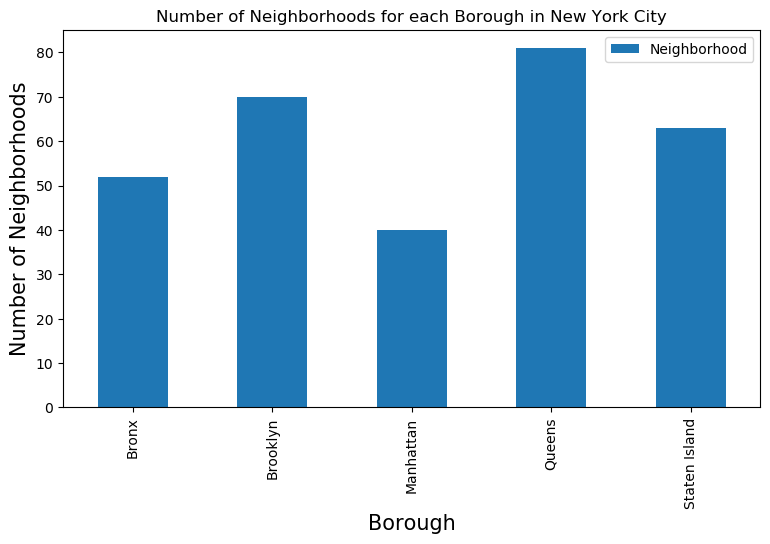

In [10]:
#Plotiing to visualize the dataset

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for each Borough in New York City')
#On x-axis
plt.xlabel('Borough name', fontsize = 15)
#On y-axis
plt.ylabel('Number of Neighborhoods', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the above visualiaztion we can observe that Borough Queens has the highest number of neighborhoods when compared to the others.

Now Lets narrow down to highlights the African resturants available in each of these neighbourhoods.

In [ ]:
# prepare neighborhood list that contains african restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
african_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    african_resturants=venues[venues['Category']=='African Restaurant']   
    print('(',count,'/',len(new_york_data),')','African Resturants in '+Neighborhood+', '+Borough+':'+str(len(african_resturants)))
    for resturant_detail in african_resturants.values.tolist():
        id, name , category=resturant_detail
        african_rest_ny = african_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) African Resturants in Wakefield, Bronx:0
( 2 / 306 ) African Resturants in Co-op City, Bronx:0
( 3 / 306 ) African Resturants in Eastchester, Bronx:0
( 4 / 306 ) African Resturants in Fieldston, Bronx:0
( 5 / 306 ) African Resturants in Riverdale, Bronx:0
( 6 / 306 ) African Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) African Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) African Resturants in Woodlawn, Bronx:0
( 9 / 306 ) African Resturants in Norwood, Bronx:0
( 10 / 306 ) African Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) African Resturants in Baychester, Bronx:0
( 12 / 306 ) African Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) African Resturants in City Island, Bronx:0
( 14 / 306 ) African Resturants in Bedford Park, Bronx:0
( 15 / 306 ) African Resturants in University Heights, Bronx:2
( 16 / 306 ) African Resturants in Morris Heights, Bronx:0
( 17 / 306 ) African Resturants in Fordham, Bronx:1
( 18 / 306 ) African Resturants in East Tremont, Bronx:

In [ ]:
african_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix


In [ ]:
african_rest_ny.shape

(12, 4)

We got a paltry 12 African Resturants across New York City

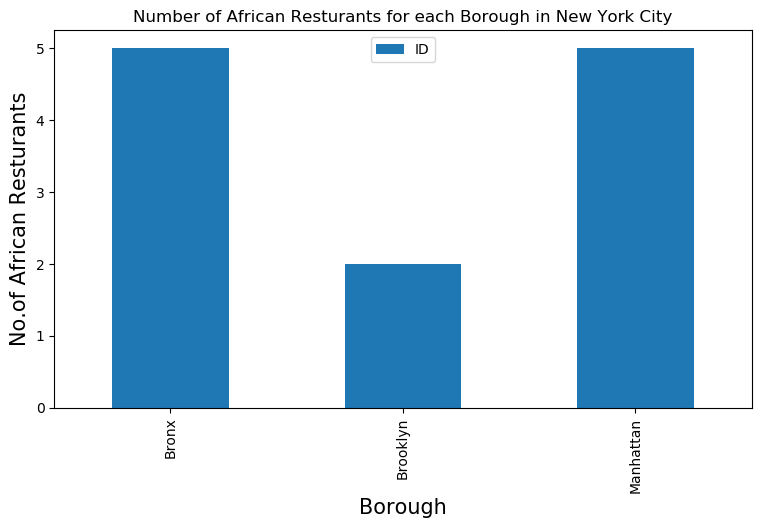

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of African Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of African Resturants', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Bronx and Manhattan have the largest number of African resturants

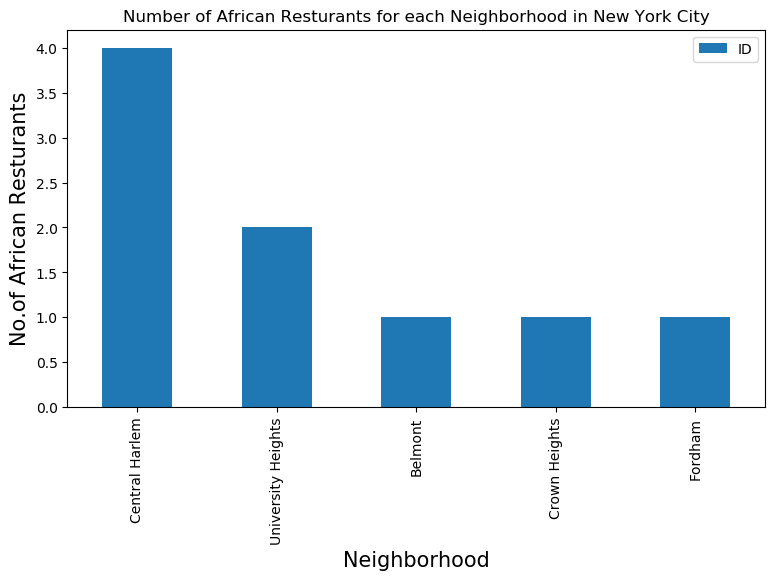

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of African Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of African Resturants', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
african_rest_ny[african_rest_ny['Neighborhood']=='Central Harlem']

,Borough,Neighborhood,ID,Name
6,Manhattan,Central Harlem,53e01975498e78c0915599bf,Ponty Bistro Harlem
7,Manhattan,Central Harlem,4c2fdced452620a120551e0f,Keur Sokhna
8,Manhattan,Central Harlem,4a9ea132f964a520ad3a20e3,Africa Kine Restaurant
9,Manhattan,Central Harlem,5004a9e5e4b034c2950659fd,Les Ambassades Senegalais Bistro


So Central harlem and University Heights have got the highest number of African Resturants with a total count of 6.

Now we will get the ranking of each resturant for further analysis.

In [ ]:
# prepare neighborhood list that contains african resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
african_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in african_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(african_rest_ny),')','processed')
    african_rest_stats_ny = african_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID             Name  Likes  Rating  Tips
0  4c2f8b1b7cc0c9b6a1eaeb9a  Accra Resturant      9     6.8     3
( 1 / 12 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.8     3
( 2 / 12 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.8     3
( 3 / 12 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.8     3
( 4 / 12 ) processed
                         ID          Name  Likes  Rating  Tips
0  51d4d2cc454a777ed5a76c57  Cafe Rue Dix    198     8.6    57
( 5 / 12 ) processed
                         ID                 Name  Likes  Rating  Tips
0  53e01975498e78c0915599bf  Ponty Bistro Harlem    101     8.6    29
( 6 / 12 ) processed
                         ID                 Name  Likes  Rating  Tip

In [ ]:
african_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant,9,6.8,3
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix,198,8.6,57


In [ ]:
african_rest_stats_ny.shape

(12, 7)

In [ ]:
african_rest_ny.shape

(12, 4)

Now lets save our restaurant data to a csv sheet. This is to safeguard against modifying our hard work :) As per Foursquare API calls, we only have 500 premium calls per day to retrieve venue details. So, going forward, we will refer to the saved data sheet csv if required.

In [ ]:
african_rest_stats_ny.to_csv('african_rest_stats_ny.csv', index=False)

To be sure nothing is broken, lets verify the data from our saved csv file.

In [ ]:
african_rest_stats_ny_csv=pd.read_csv('african_rest_stats_ny.csv')

In [ ]:
african_rest_stats_ny_csv.shape

(12, 7)

In [ ]:
african_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant,9,6.8,3
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix,198,8.6,57


Evidently, we are good to go!

In [ ]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
Borough         12 non-null object
Neighborhood    12 non-null object
ID              12 non-null object
Name            12 non-null object
Likes           12 non-null object
Rating          12 non-null float64
Tips            12 non-null object
dtypes: float64(1), object(6)
memory usage: 752.0+ bytes


In [ ]:
african_rest_stats_ny['Likes']=african_rest_stats_ny['Likes'].astype('float64')

In [ ]:
african_rest_stats_ny['Tips']=african_rest_stats_ny['Tips'].astype('float64')

In [ ]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
Borough         12 non-null object
Neighborhood    12 non-null object
ID              12 non-null object
Name            12 non-null object
Likes           12 non-null float64
Rating          12 non-null float64
Tips            12 non-null float64
dtypes: float64(3), object(4)
memory usage: 752.0+ bytes


Now the data types looks good.

In [ ]:
# Resturant with maximum Likes
african_rest_stats_ny.iloc[african_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                198
Rating                               8.6
Tips                                  57
Name: 4, dtype: object

In [ ]:
# Resturant with maximum Rating
african_rest_stats_ny.iloc[african_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                198
Rating                               8.6
Tips                                  57
Name: 4, dtype: object

In [ ]:
# Resturant with maximum Tips
african_rest_stats_ny.iloc[african_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                198
Rating                               8.6
Tips                                  57
Name: 4, dtype: object

In [ ]:
ny_neighborhood_stats=african_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [ ]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
2,Crown Heights,8.6
4,Hamilton Heights,8.6
0,Belmont,7.8
3,Fordham,7.8
1,Central Harlem,7.7


The above ratings are for the top neighbourhoods with the top average rating of African resturants

In [ ]:
ny_borough_stats=african_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [ ]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.88
1,Brooklyn,7.45
0,Bronx,7.40


Similarly these are the average ratings of African Resturants for each Borough.

Lets put some visuals to this data

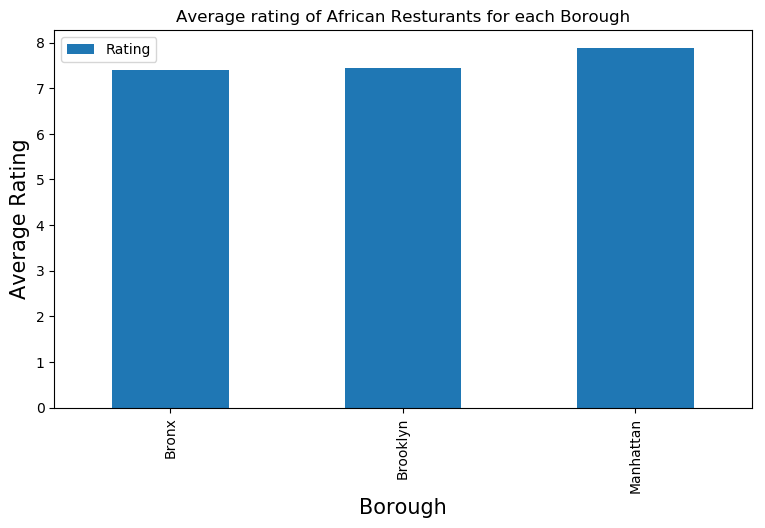

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of African Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
african_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 7.5 to visualize on map

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.5]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Belmont,7.8
1,Central Harlem,7.7
2,Crown Heights,8.6
3,Fordham,7.8
4,Hamilton Heights,8.6


We will join this dataset to original new york data to get lonitude and latitude

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Belmont,40.857277,-73.888452,7.8
1,Manhattan,Central Harlem,40.815976,-73.943211,7.7
2,Brooklyn,Crown Heights,40.670829,-73.943291,8.6
3,Bronx,Fordham,40.860997,-73.896427,7.8
4,Manhattan,Hamilton Heights,40.823604,-73.949688,8.6


Now we will show this data on a map

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighbourhoods. 

Lets Visualize Boroughs based on average rating.

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
#ny_geo = r'Borough_Boundaries.geojson'
ny_geo = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON'

#ny_map.choropleth(
folium.Choropleth(
    geo_data=ny_geo,
    name='choropleth',
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

ny_map
# display map
# as this is huge map data , we will save it to a file
#ny_map.save('borough_rating.html')

## Results 

From this analysis, out of the 306 neighbourhoods in New York City, there are  12 African restaurants that are spreaded across the city. The result is unpredictable considering the large number of Africans living in New York City. Restaurants in Crown heights have the highest number of ratings. While Manhattan takes the lead for the Boroughs. This result is solely based on the data pulled from the Foursquare API.

## Observations

We could observe that, Manhattan has the highest number of African restaurants and then followed by Bronx and Brooklyn. This makes it just 3 out of the 5 Boroughs housing African restaurants.


## Conclusion

The opportunity exists to set up an African restaurant. The market for African cuisine is available but the supply seems to be  below the demand. We could say that the competition is not much. Thus, I can conclude that opening a African restaurant is a good idea that I will suggest to the client.
